In [1]:
# импортируем библиотеки

import pandas as pd
import pandahouse
import numpy as np
import hashlib
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from swifter import swifter

In [2]:
# считываем нужные данные из clickhouse в датафрейм
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230820'
}

q = '''
SELECT
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    {db}.feed_actions 
WHERE 
    toDate(time) BETWEEN '2023-07-30' AND '2023-08-05'
    AND exp_group IN (1, 2)
GROUP BY exp_group, user_id
'''

df1 = pandahouse.read_clickhouse(q, connection=connection)

#выводим заголовок датафрейма
print(df1.head())

   exp_group  user_id  likes  views       ctr
0          1   109963      3     15  0.200000
1          1    26117     32    141  0.226950
2          1   138232     18     73  0.246575
3          1    18392      7     32  0.218750
4          1    26295     39    141  0.276596


In [3]:
# посмотрим на описательную статистику ctr по группам
df1.groupby('exp_group').ctr.describe()

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
1,10020.0,0.216774,0.082969,0.0,0.163636,0.205882,0.257870,0.722222
2,9877.0,0.216102,0.142870,0.0,0.096774,0.153285,0.323529,0.900000


Средние значения CTR в тестовой и контрольной группах отличаются только с четвертого знака после запятой, но есть явные различия в стандартном отклонении и квантилях.

<Axes: xlabel='ctr', ylabel='Count'>

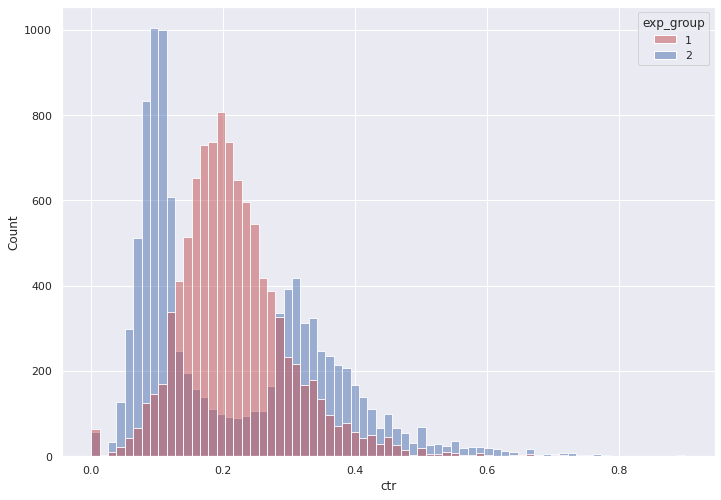

In [22]:
# увеличим размер графика
sns.set(rc={'figure.figsize':(11.7,8.27)})

# построим гистограмму и визуально оценим распределение значений ctr в тестовой и контрольной группах
sns.histplot(data=df1, x='ctr', hue='exp_group', palette=['r', 'b'])

Визуально заметны различия. Распределение CTR в тестовой группе является двугорбым, в то время как в контрольной группе оно приближено к нормальному. Такое наблюдение может указывать на наличие различий в поведении пользователей в двух группах. Причиной двугорбости может быть влияние нового алгоритма рекомендации на разные сегменты пользователей. Например, на один сегмент алгоритм может оказывать положительное воздействие, а на другой - отрицательное.

In [5]:
# для удобства введем переменные для контрольной и тестовой групп
control = df1[df1.exp_group == 1]
test = df1[df1.exp_group == 2]

In [6]:
# t-тест
stats.ttest_ind(test.ctr, control.ctr, equal_var=False)

Ttest_indResult(statistic=-0.4051491913112757, pvalue=0.685373331140751)

T-тест не фиксирует статистически значимых различий, но он предполагает, что данные в выборках имеют нормальное распределение, и если это не выполняется, результаты теста могут быть неправильными. А ранее было отмечено, распеределение в контрольной группе двугорбое.

In [7]:
# тест Манна-Уитни

stats.mannwhitneyu(test.ctr, control.ctr)

MannwhitneyuResult(statistic=43777627.0, pvalue=4.632205841806026e-45)

Тест Манна-Уитни прокрасился, зафиксировано статистически значимое различие. Возможно, причина состоит в том, что он основан не на проверке равенства средних значений, а на сравнении двух независимых выборок и определении, отличаются ли они друг от друга в целом.

# Сглаженный CTR 

In [8]:
# напишем функцию для получения сглаженного CTR

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [9]:
# посчитаем глобальный CTR в группах

control_global_ctr = control.likes.sum() / control.views.sum()
test_global_ctr = test.likes.sum() / test.views.sum()

In [10]:
# добавим к данным метрику сглаженный CTR

control['smoothed_ctr'] = get_smothed_ctr(control.likes, control.views, control_global_ctr, 5)

test['smoothed_ctr'] = get_smothed_ctr(test.likes, test.views, test_global_ctr, 5)

/tmp/ipykernel_368/4206524274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['smoothed_ctr'] = get_smothed_ctr(control.likes, control.views, control_global_ctr, 5)
/tmp/ipykernel_368/4206524274.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['smoothed_ctr'] = get_smothed_ctr(test.likes, test.views, test_global_ctr, 5)


In [11]:
# описательная статистика
pd.concat([control, test]).groupby('exp_group').smoothed_ctr.describe()

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
1,10020.0,0.215280,0.069918,0.029943,0.167667,0.206353,0.252001,0.623289
2,9877.0,0.212508,0.123362,0.031289,0.106683,0.157961,0.310366,0.766708


<Axes: xlabel='ctr', ylabel='Count'>

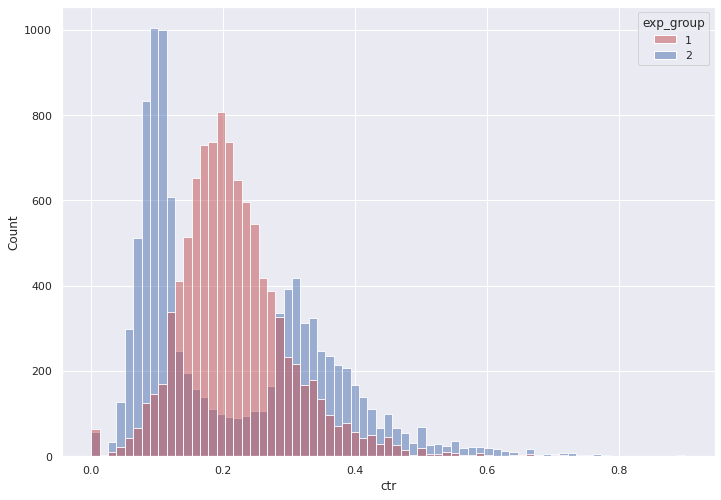

In [23]:
# визуализация распределений
sns.histplot(data=df1, x='ctr', hue='exp_group', palette=['r', 'b'])

In [13]:
# t-тест
stats.ttest_ind(control.smoothed_ctr, test.smoothed_ctr, equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

Значение pvalue в t-тесте стало значительно меньше, но не позволяет отклонить гипотезу о равенстве средних и как было отмечено раннее тест может не работать из-за отклонения распределения от нормального.

In [14]:
# тест Манна-Уитни
stats.mannwhitneyu(control.smoothed_ctr, test.smoothed_ctr)

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

В целом наблюдения по анализу метрики сглаженный CTR те же, что и по обычному CTR. Визуальных отличий не замечено, описательная статистика имеет схожие тенденции, тесты показывают аналогичные результаты.

# Пуассоновский бутстреп

Попробуем сравнить общегрупповой CTR, для этого нагенерируем псевдовыборки с возращением, применив разобранный в лекции Пуассоновский бутстреп

<Axes: ylabel='Count'>

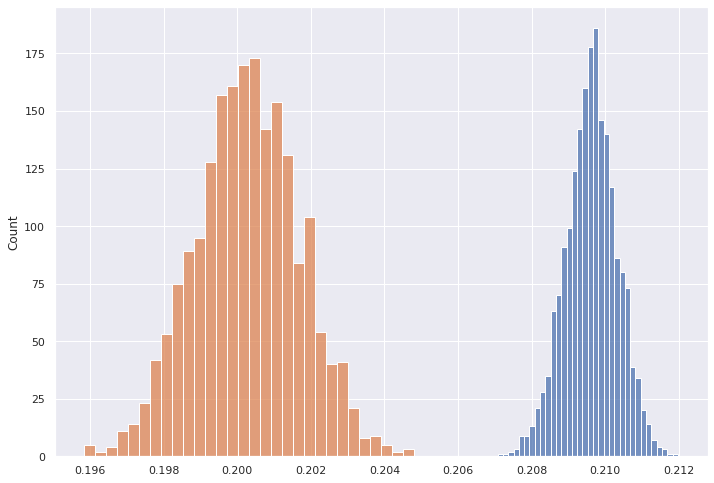

In [24]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = control.likes.to_numpy()
views1 = control.views.to_numpy()
likes2 = test.likes.to_numpy()
views2 = test.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Распределения общегрупповых CRT по псевдовыборкам из тестовой и контрольной групп не пересекаются, следовательно можно утверждать что различия статистически значимы, p-value при проведения тестов будет равен 0.

<Axes: ylabel='Count'>

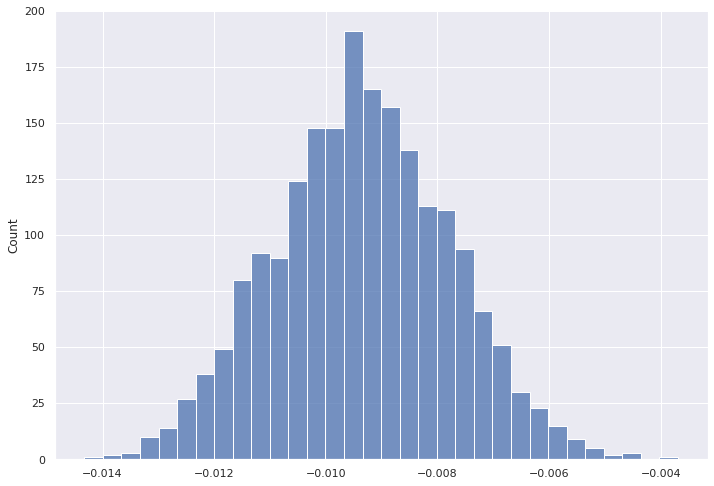

In [25]:
# визуализируем распределние разницы глобальных CTR
sns.histplot(ctr2 - ctr1)

Распределение разницы глобальных CTR тестовой и котрольной групп не пересекает ноль, все значения отрицательные. Это позволяет нам утверждать с помощью бутстрепа, что тестовая группа показала худший результат по CTR чем контрольная.

# Бакетное преобразование

In [17]:
# считываем нужные данные из clickhouse в датафрейм
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-07-30' and '2023-08-05'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df2 = pandahouse.read_clickhouse(q, connection=connection)

# выводи заголовок датафрейма
print(df2.head())


   exp_group  bucket  bucket_ctr
0          1       0    0.200592
1          2       0    0.196510
2          1       1    0.208799
3          2       1    0.210375
4          1       2    0.204632


In [18]:
# описательная статистика
df2.groupby('exp_group').bucket_ctr.describe()

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
1,50.0,0.209694,0.004261,0.199407,0.207635,0.209667,0.212077,0.218501
2,50.0,0.200457,0.010824,0.180041,0.193531,0.197906,0.205990,0.229383


<Axes: xlabel='bucket_ctr', ylabel='Count'>

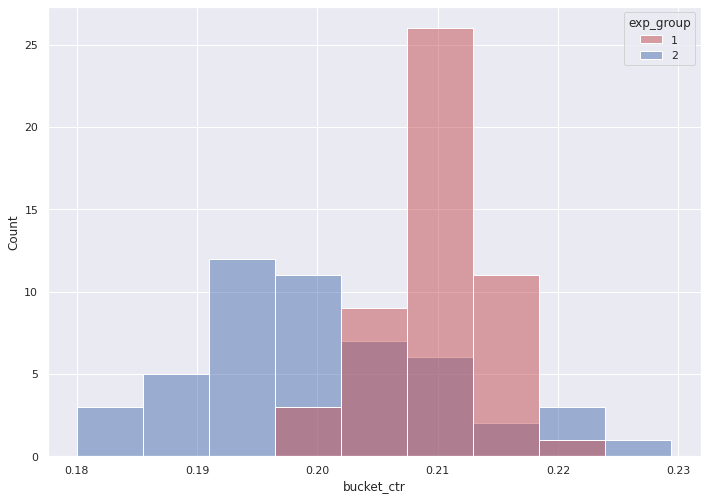

In [26]:
# визуализируем распределение бакетного CTR
sns.histplot(df2, x='bucket_ctr', 
             hue='exp_group', 
             palette=['r', 'b'])

Явно заметны различия, сами распределения не критично отклонены от нормальных.

In [20]:
# t-тест
stats.ttest_ind(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [21]:
# тест Манна-Уитни
stats.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr)

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Среднее значение бакетного CTR выше в контрольной группе, t-тест и тест Манна-Уитни прокрашиваются, есть основания предполагать что различия статистически значимы.

# Выводы
Краткие выводы по каждому из примененых методов анализа были приведены выше. В целом есть основания утверждать, что метрика CTR в тестовой группе оказалась ниже и различия статистически значимы, поэтому не рекомендуется раскатывать новый алгоритм на всех пользователей. В то же время стоит отметить, что преположительно на некоторые сегменты пользователей новый алгоритм влияет положительно и имеет смысл провести дополнительный анализ для выявления этих сегментов.